In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from multiscorer import MultiScorer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
import xgboost as xgb
import time

In [3]:
df= pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
df.shape

(7043, 21)

In [9]:
df.duplicated().sum()

0

In [11]:
df['TotalCharges']

0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: TotalCharges, Length: 7043, dtype: object

In [12]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'] , errors='coerce')
df.TotalCharges.dtype

dtype('float64')

In [13]:
df['TotalCharges']

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [16]:
df.skew()

SeniorCitizen     1.833633
tenure            0.239540
MonthlyCharges   -0.220524
TotalCharges      0.961642
dtype: float64

In [17]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [18]:
df.drop(['customerID'],inplace=True, axis=1)

In [23]:
df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

## EDA

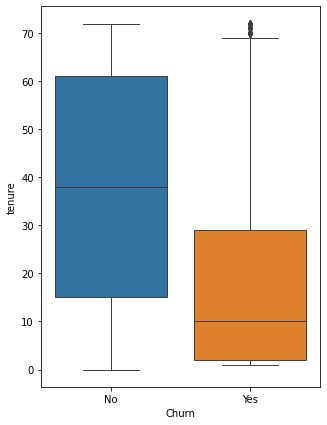

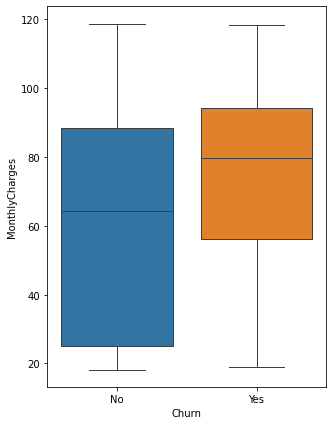

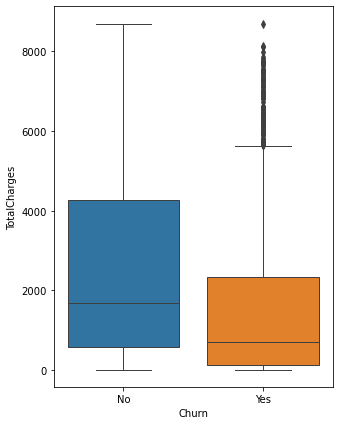

In [25]:
for i in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    plt.figure(figsize=(5,7))
    sns.boxplot(x=df.Churn, y=df[i],data=df, linewidth=1)
    plt.show()
    

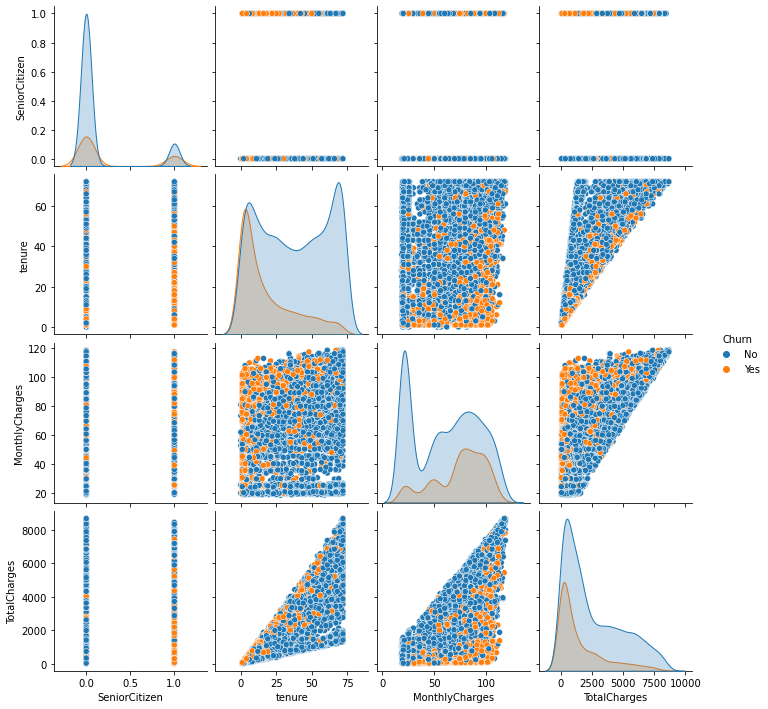

In [28]:
sns.pairplot(df, hue='Churn')

## Building a model

In [30]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

now we are going to define a function before get dummies, to convert categorical columns into indicator variables in the same column instead of splitting into two or more columns.

In [35]:
def change_yes_no(x):
    if x =='Yes' or x == 'Male':
        return 1
    elif x == 'No' or x == 'Female' :
        return 0
    else:
        return x
    
    
for i in df.columns:
    if len(df[i].unique()) == 2:
        df[i] = df[i].map(change_yes_no)

In [41]:
df_dummies = pd.get_dummies(df,drop_first=True)
df_dummies.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,0,0,0,0,0,0,0,0,1,0


In [43]:
df_dummies.dropna(inplace=True)
df_dummies.shape

(7032, 31)

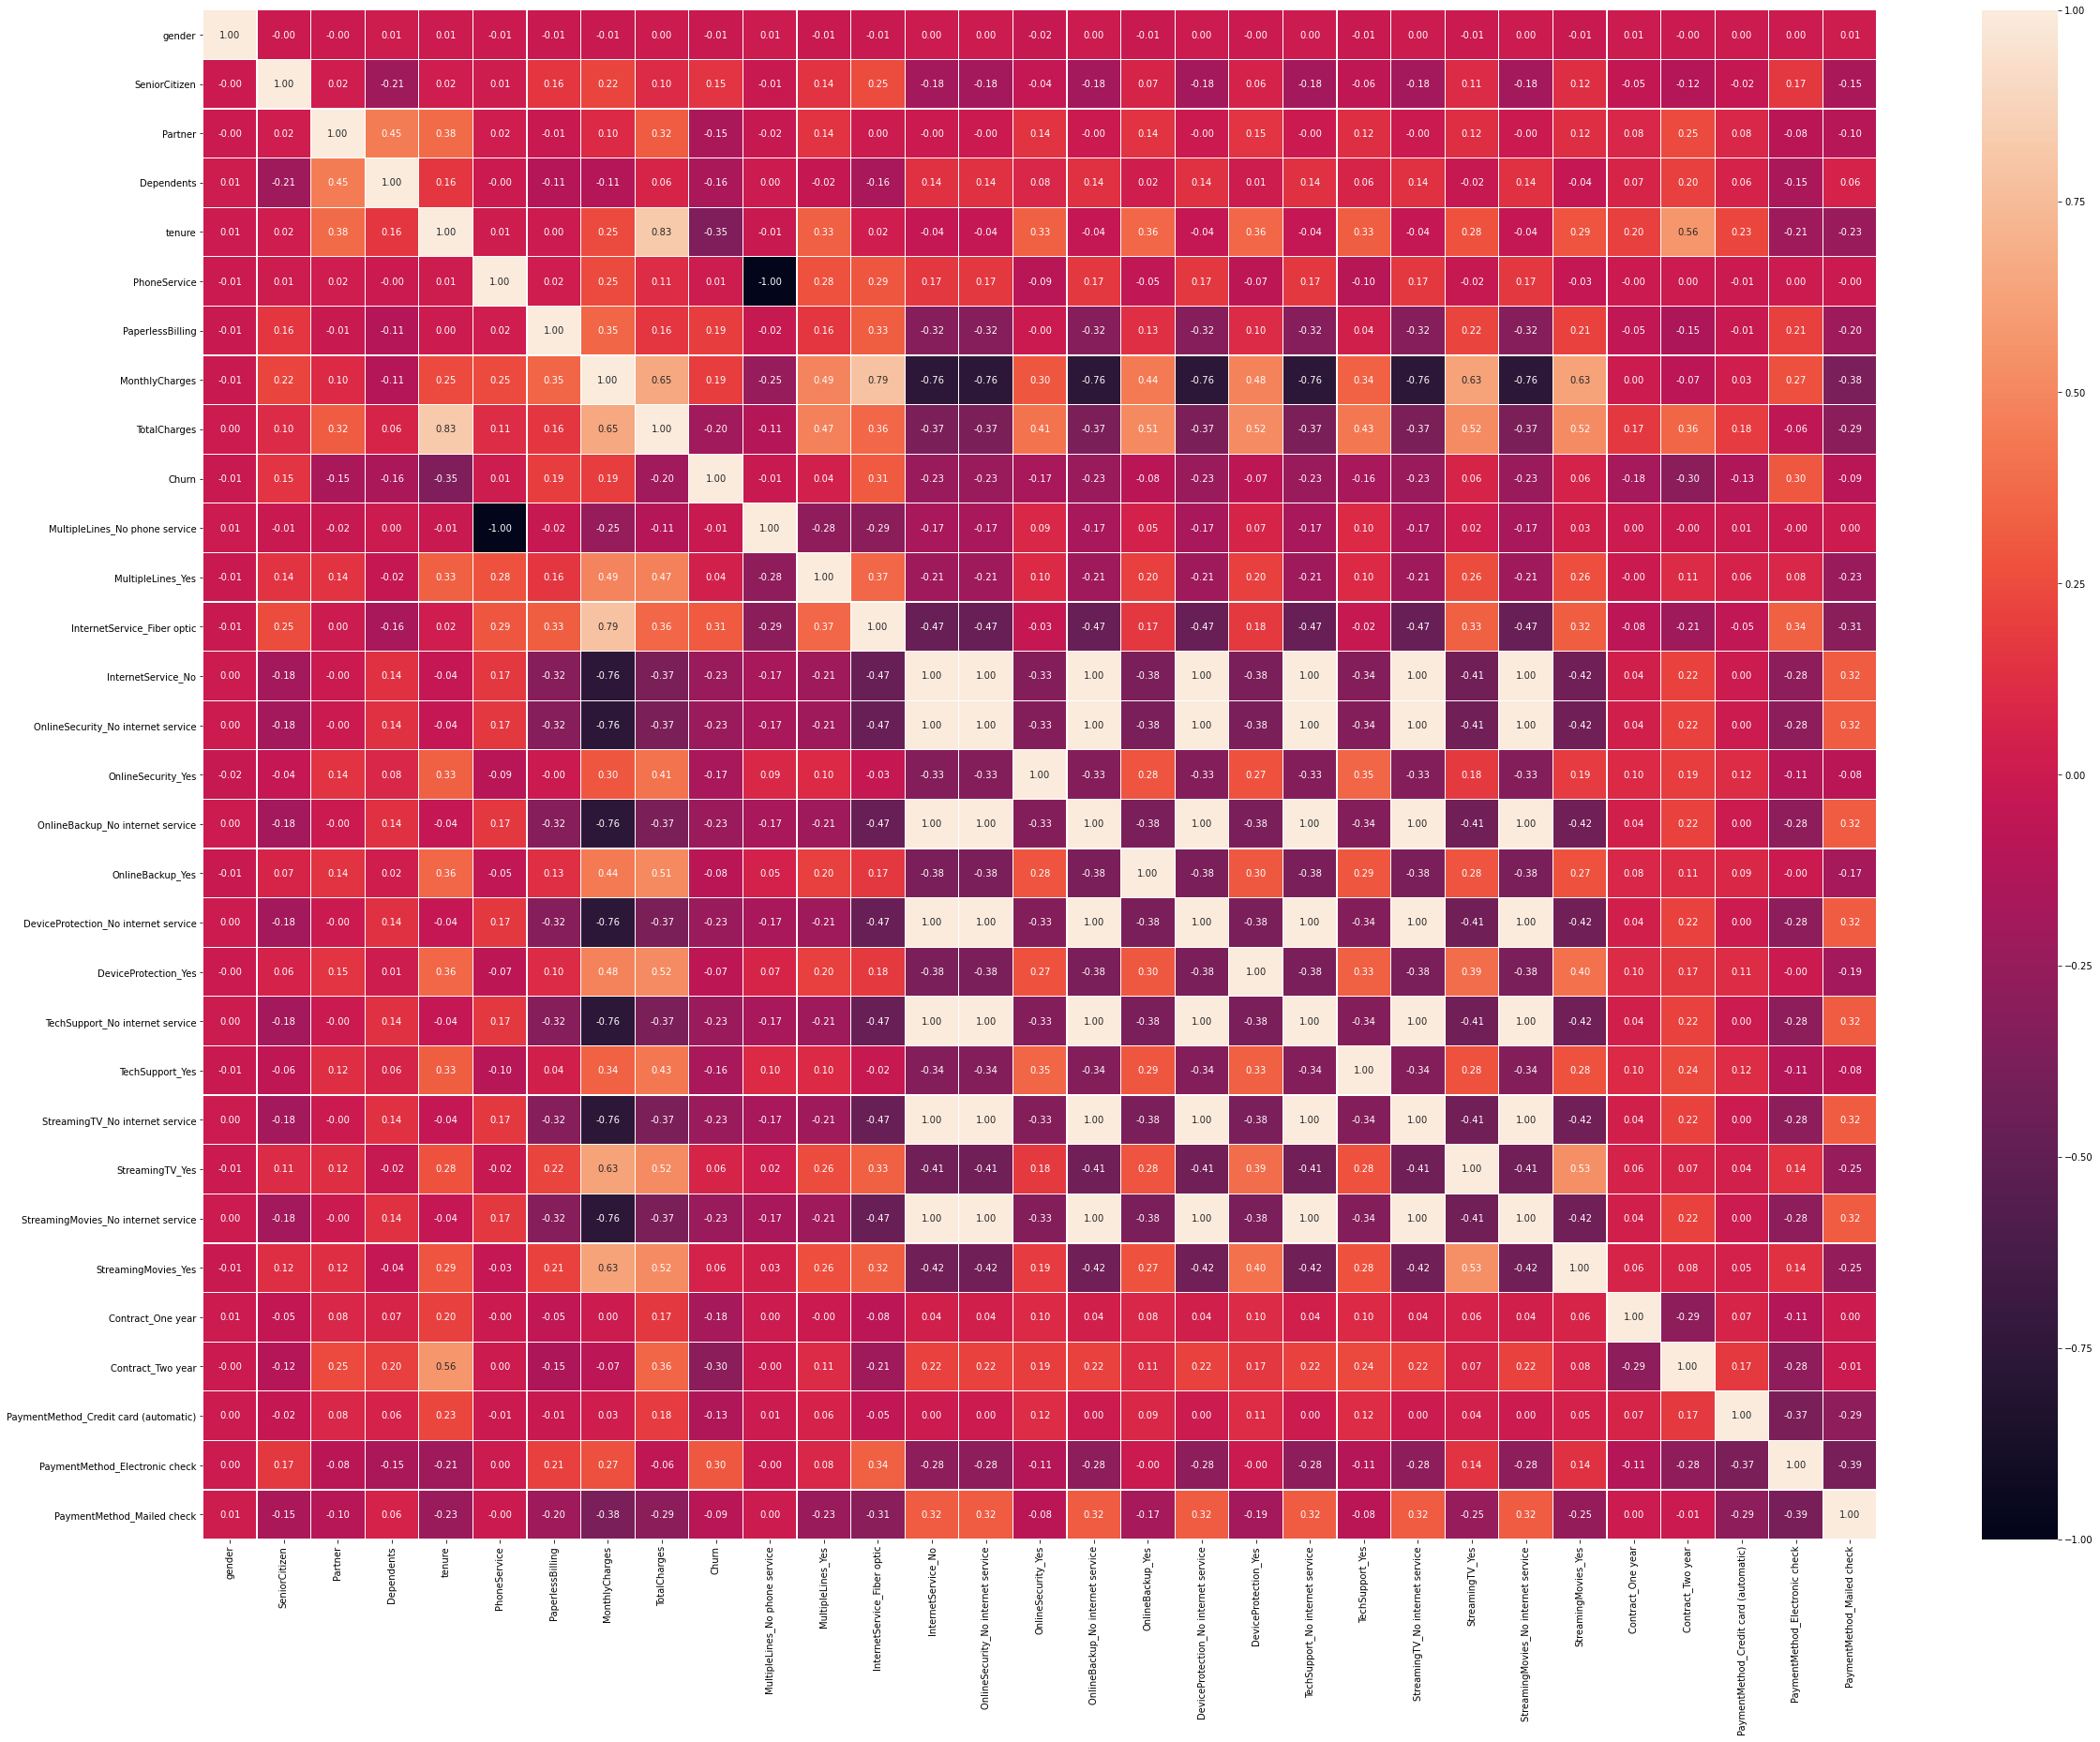

In [45]:
plt.figure(figsize = (40, 30))
sns.heatmap(df_dummies.corr(), annot = True, linewidths=0.2, fmt=".2f");

In [79]:
X = df_dummies.drop('Churn' , axis=1)
y = df_dummies['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=True)

In [73]:
X_train

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No phone service,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
792,0,0,1,1,8,1,1,19.85,146.60,0,...,0,1,0,1,0,0,1,0,0,1
4409,1,1,1,0,71,0,0,46.35,3353.40,1,...,1,0,0,0,0,0,1,1,0,0
1387,1,0,1,1,72,1,0,24.30,1643.25,0,...,0,1,0,1,0,0,1,0,0,0
466,1,1,1,0,64,1,0,102.10,6538.45,0,...,1,0,1,0,1,0,1,0,1,0
4076,1,0,1,0,70,1,1,99.35,6944.50,0,...,0,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6380,1,1,1,0,65,1,1,104.35,6578.55,0,...,0,0,1,0,1,0,0,0,1,0
3756,1,0,0,0,1,0,1,24.45,24.45,1,...,0,0,0,0,0,0,0,0,0,1
4964,0,0,0,0,26,1,1,74.95,1834.95,0,...,0,0,0,0,0,0,0,0,0,0
3700,1,0,0,1,20,1,1,19.40,374.50,0,...,0,1,0,1,0,0,0,0,1,0


In [74]:
X_test

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No phone service,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5278,0,0,1,1,56,1,1,109.60,5953.00,0,...,1,0,1,0,1,0,0,0,0,1
4374,1,0,1,1,71,1,1,19.60,1387.45,0,...,0,1,0,1,0,0,1,0,0,0
5464,1,0,0,0,25,1,1,20.75,499.40,0,...,0,1,0,1,0,0,1,0,0,1
1006,0,0,0,0,18,1,1,90.10,1612.75,0,...,1,0,0,0,1,0,0,0,1,0
6590,0,0,0,0,1,1,1,70.85,70.85,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4718,0,0,1,0,20,1,1,20.00,416.45,0,...,0,1,0,1,0,1,0,0,0,1
3246,1,0,0,0,3,1,0,55.15,159.15,0,...,0,0,1,0,0,0,0,0,0,1
1620,0,0,1,1,2,0,0,29.05,44.75,1,...,1,0,0,0,0,0,0,0,0,0
749,0,0,0,0,63,1,1,90.05,5817.00,0,...,1,0,1,0,0,1,0,1,0,0


In [82]:
# Create an array of models
models = []
models.append(("LogisticRegression", LogisticRegression()))
models.append(("GaussianNB", GaussianNB()))
models.append(("RandomForestClassifier", RandomForestClassifier()))
models.append(("SVC", SVC()))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
models.append(("xgb.XGBClassifier", xgb.XGBClassifier(eval_metric='mlogloss')))
models.append(("KNeighborsClassifier", KNeighborsClassifier()))



# Measuring the metrics of the different models

scorer = MultiScorer({'accuracy'  : (accuracy_score , {}), 
                      'f1_score'  : (f1_score       , {'pos_label': 3, 'average':'macro'}), 
                      'recall'    : (recall_score   , {'pos_label': 3, 'average':'macro'}), 
                      'precision' : (precision_score, {'pos_label': 3, 'average':'macro'})
                     })

# A dictionary for all the distinct models and their respective metrics
model_scores_dict = {'model_name' : [], 
                     'accuracy'   : [], 
                     'f1_score'   : [], 
                     'recall'     : [], 
                     'precision'  : [],
                     'time'       : []
                    }

# For each model name and model in models
for model_name, model in models: 
    
    # Add model_name to model_scores_dict 
    model_scores_dict['model_name'].append(model_name)
    #print(model_name)
    kfold = KFold(n_splits=2, random_state=42, shuffle=True)
    start = time.time()
    _ = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scorer)
    cv_result = scorer.get_results()
    
    # For each metric in cv_result.keys()
    for metric_name in cv_result.keys():
        # Get the average of cv_result[metric_name]
        average_score = np.average(cv_result[metric_name])
        # Update model_scores_dict with average_score for model_name
        model_scores_dict[metric_name].append(average_score)
        #print('%s : %f' %(metric_name, average_score))

    model_scores_dict['time'].append((time.time() - start))
    #print('time : ', time.time() - start, '\n\n')
        
model_score_df = pd.DataFrame(model_scores_dict).set_index("model_name")
model_score_df.sort_values(by=["accuracy", "f1_score", "time"], ascending=False)

/Users/Sam/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1360: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Users/Sam/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1360: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Users/Sam/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1360: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Users/Sam/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1360: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got 'm

/Users/Sam/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1360: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Users/Sam/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1360: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Users/Sam/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1360: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Users/Sam/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future rel

,accuracy,f1_score,recall,precision,time
model_name,,,,,
LogisticRegression,0.803021,0.732374,0.720184,0.752810,0.120357
SVC,0.762932,0.699546,0.708548,0.727051,2.170264
xgb.XGBClassifier,0.758488,0.690934,0.695630,0.711763,1.835164
KNeighborsClassifier,0.758247,0.689454,0.692839,0.708121,0.766295
DecisionTreeClassifier,0.754204,0.689001,0.696718,0.710600,0.049199
RandomForestClassifier,0.752532,0.695637,0.712750,0.721689,1.082682
GaussianNB,0.735110,0.692430,0.725254,0.716812,0.037088


In [78]:
from sklearn.metrics import accuracy_score, classification_report

tree= DecisionTreeClassifier(random_state=42) # using the random state for reproducibility
forest= RandomForestClassifier(random_state=42)
knn= KNeighborsClassifier()
svm= SVC(random_state=42)
xboost= xgb.XGBClassifier(random_state=42)

X = df_dummies.drop('Churn' , axis=1)
y = df_dummies['Churn']


models= [tree, forest, knn, svm, xboost]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state=0)


for model in models:
    model.fit(X_train, y_train) # fit the model
    y_pred= model.predict(X_test) # then predict on the test set
    accuracy= accuracy_score(y_test, y_pred) # this gives us how often the algorithm predicted correctly
    clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The accuracy of model {type(model).__name__} is {accuracy:.2f}")
    print(clf_report)
    print("\n")


The accuracy of model DecisionTreeClassifier is 0.73
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1038
           1       0.49      0.50      0.49       369

    accuracy                           0.73      1407
   macro avg       0.65      0.65      0.65      1407
weighted avg       0.73      0.73      0.73      1407



The accuracy of model RandomForestClassifier is 0.79
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1038
           1       0.62      0.49      0.55       369

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



The accuracy of model KNeighborsClassifier is 0.76
              precision    recall  f1-score   support

           0       0.81      0.88      0.85      1038
           1       0.56      0.44      0.49       369

    accuracy         

/Users/Sam/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Sam/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Sam/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Sam/opt/anaconda3/

The accuracy of model SVC is 0.74
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1038
           1       0.00      0.00      0.00       369

    accuracy                           0.74      1407
   macro avg       0.37      0.50      0.42      1407
weighted avg       0.54      0.74      0.63      1407



[17:47:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The accuracy of model XGBClassifier is 0.80
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1038
           1       0.63      0.52      0.57       369

    accuracy                           0.80      1407
   macro avg  

In [80]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler().fit_transform(X) 

X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size = 0.2 , random_state=0)
for model in models:
    model.fit(X_train, y_train) # fit the model
    y_pred= model.predict(X_test) # then predict on the test set
    accuracy= accuracy_score(y_test, y_pred) # this gives us how often the algorithm predicted correctly
    clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The accuracy of model {type(model).__name__} is {accuracy:.2f}")
    print(clf_report)
    print("\n")

The accuracy of model DecisionTreeClassifier is 0.73
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1038
           1       0.49      0.50      0.49       369

    accuracy                           0.73      1407
   macro avg       0.65      0.66      0.65      1407
weighted avg       0.73      0.73      0.73      1407



The accuracy of model RandomForestClassifier is 0.79
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1038
           1       0.62      0.49      0.55       369

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.78      0.79      0.78      1407



The accuracy of model KNeighborsClassifier is 0.76
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1038
           1       0.55      0.51      0.53       369

    accuracy         

/Users/Sam/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The accuracy of model XGBClassifier is 0.80
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1038
           1       0.63      0.52      0.57       369

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407





Data is unbalanced so I will use OverSampling. first conda install -c glemaitre imbalanced-learn